<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/06_TC1_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the libraries

In [23]:
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif
from keras.utils import to_categorical
from google.colab import drive
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation   

In [24]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)
#TC1data15 = sfeatures1


In [26]:
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')


In [27]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [28]:
# outcome = encode(outcome['Project_id'])

# Random Forest

In [29]:
np.random.seed(123)
# define the model
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# fit the model
model.fit(TC1data15, outcome['Project_id'])



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [30]:
# get importance
importance = model.feature_importances_


In [31]:
feature = pd.DataFrame()
feature['name'] = TC1data15.columns

In [32]:
feature['importance'] = importance
feature

,name,importance
0,TSPAN6,0.000299
1,TNMD,0.000014
2,DPM1,0.000002
3,SCYL3,0.000063
4,C1orf112,0.000039
...,...,...
60478,Metazoa_SRP.305,0.000000
60479,AJ271736.1.1,0.000000
60480,MIR6089.1,0.000000
60481,RP13-465B17.5.1,0.000000


In [33]:
feature_sort = feature.sort_values(by='importance',ascending=False)


# ConvNN(RF) - top 150

## Train/Test split    

In [34]:
# from keras.utils import to_categorical
outcome = encode(outcome['Project_id'])

Shape of data (BEFORE encode): (4500,)
Shape of data (AFTER  encode): (4500, 15)



In [35]:
#feature_sort_selected = feature_sort[feature_sort['importance'] > 0.001]
feature_sort_selected = feature_sort.iloc[:150,:]
feature_sort_selected

,name,importance
3300,MOGAT3,0.003089
57644,FP671120.6,0.002802
12189,KLK4,0.002783
1448,CDH17,0.002782
17545,KLHL14,0.002726
...,...,...
8372,LYPLAL1,0.000929
5174,CSTA,0.000928
7744,ENPEP,0.000920
16372,TRABD2A,0.000915


In [36]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [38]:
X_train

,MOGAT3,FP671120.6,KLK4,CDH17,KLHL14,NAPSA,VTN,SFTPB,RDH11,RP11-452C8.1,SOX17,SFTPA1,CRYGN,RP11-53M11.5,FP671120.4,AP001187.9,KLK2,F13B,S1PR5,HRG,KLK3,ITIH2,TRPS1,RP5-1021I20.2,ACSM2B,UGT2B4,PRODH2,FEV,MASP2,SFTPC,FP236383.4,KCNJ10,PRAC2,GRHL2,SFTA3,SLC28A1,NXPE1,LINC00483,CHRNA2,SFTPA2,...,SLC13A1,DHRS7,PCAT14,THRSP,RP11-320M16.1,SLC17A5,HNF1B,CITED1,EMX2OS,DAB2,RP11-894P9.2,FAM83D,SOX15,PHGR1,NCAPH,HOXA11-AS,REEP5,C2orf72,PKMP3,HIST1H4C,STX18,NKX2-1,TSPAN8,SFTPD,AC079949.1,GPRASP1,ZNF761,HNF4A,TRIM31,STK32A,SCGB3A2,TMTC2,CTD-2182N23.1,CTD-2033D15.3,MTATP8P1,LYPLAL1,CSTA,ENPEP,TRABD2A,IYD
849,0.000000,0.000000,0.000000,0.808450,0.000000,3.672119,0.000000,4.346068,1.155254,0.0,0.424186,3.167719,0.000000,0.000000,0.465801,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.094042,0.000000,0.000000,0.022084,0.000000,0.0,0.000000,1.362394,0.000000,0.0,0.000000,1.636991,2.317114,0.000000,0.0,0.0,0.0,3.142535,...,0.000000,1.722872,0.0,0.000000,0.000000,1.404875,1.387987,0.000000,0.000000,1.216216,0.000000,0.742966,0.574371,0.000000,0.391520,0.000000,2.224036,0.000000,0.000000,0.001468,1.307300,2.334584,2.117538,3.530239,0.000000,0.506487,1.195097,0.000000,0.624641,1.173266,3.894196,0.568636,0.000000,0.000000,0.323987,1.774033,0.659895,0.378688,0.184754,0.529635
1050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.465524,0.0,0.257574,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.773058,0.000000,0.000000,0.0,2.566138,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.110626,1.734314,0.000000,0.137554,0.0,0.0,0.0,0.000000,...,0.000000,1.877394,0.0,0.056890,0.000000,1.397143,0.000000,0.000000,0.000000,1.302443,0.000000,1.896840,0.000000,0.000000,1.476843,0.000000,1.905280,0.946957,0.000000,0.124891,1.014214,0.000000,0.000000,0.000000,0.000000,0.000000,0.656383,0.000000,0.000000,0.000000,0.000000,0.794737,0.000000,0.000000,0.695195,1.416065,0.875379,0.432093,0.000000,0.000000
835,0.000000,0.157242,0.601505,0.000000,0.000000,0.690877,0.000000,1.297473,1.752160,0.0,0.041478,0.576785,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.296192,0.444143,0.000000,0.0,0.557529,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.834996,0.000000,0.0,0.000000,1.713397,0.000000,0.000000,0.0,0.0,0.0,0.790730,...,0.000000,2.164811,0.0,0.000000,0.000000,1.264516,0.000000,0.000000,0.000000,1.108063,0.000000,2.198673,1.639945,0.000000,1.288918,0.000000,2.049239,0.091759,0.079637,0.000000,1.285677,0.000000,0.251281,0.892222,0.000000,0.426151,1.161551,0.000000,0.000000,0.000000,0.441804,0.936748,0.000000,0.000000,0.650158,1.640085,2.584387,0.579072,0.000000,0.000000
4447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.192705,0.0,0.284720,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.596492,0.000000,0.000000,0.0,0.039429,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.153790,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,1.478587,0.0,0.000000,0.000000,1.104923,1.309775,0.000000,0.169633,1.169120,0.000000,1.347202,0.000000,0.000000,1.135975,0.851538,1.852621,0.000000,0.073002,0.000000,0.991055,0.000000,0.000000,0.000000,0.000000,0.159981,1.560701,0.000000,0.234236,0.756711,0.000000,1.013137,0.000000,0.127141,0.611338,1.133352,1.272749,0.042281,0.000000,0.000000
53,0.000000,1.948668,0.000000,0.000000,1.531098,0.094371,0.000000,0.000000,1.352760,0.0,2.316836,0.000000,0.000000,1.133977,2.396390,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.550796,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.164986,0.0,0.818311,1.543859,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,1.112370,0.0,1.558533,0.581620,1.293007,0.846962,0.000000,1.340738,1.110707,0.000000,2.046446,0.930447,0.000000,1.594739,0.164553,1.987460,0.071945,0.025061,1.383111,1.287079,0.000000,0.783670,0.652411,2.339878,0.098467,0.960581,0.000000,0.417634,0.000000,0.000000,0.715914,0.000000,0.000000,0.890756,1.302296,0.695939,0.377802,0.475185,0.000000
...,...,...,

## CONV1D 

In [39]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [40]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [41]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 131, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 131, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 131, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 122, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0

In [42]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [43]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [44]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
169/169 [==============================] - 8s 44ms/step - loss: 1.7479 - acc: 0.4423 - val_loss: 0.3709 - val_acc: 0.8782

Epoch 00001: val_loss improved from inf to 0.37092, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
169/169 [==============================] - 7s 42ms/step - loss: 0.3397 - acc: 0.8906 - val_loss: 0.2738 - val_acc: 0.9120

Epoch 00002: val_loss improved from 0.37092 to 0.27380, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 3/30
169/169 [==============================] - 7s 42ms/step - loss: 0.2417 - acc: 0.9217 - val_loss: 0.2471 - val_acc: 0.9324

Epoch 00003: val_loss improved from 0.27380 to 0.24714, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 4/30
169/169 [==============================] - 8s 45ms/step - loss: 0.1942 - acc: 0.9296 - val_loss: 0.2115 - val_acc: 0.9404

Epoch 00004: val_loss improved from 0.24714 to 0.21154, saving 

In [45]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.26539793610572815
Test accuracy: 0.9537777900695801


Text(0.5, 0, 'epoch')

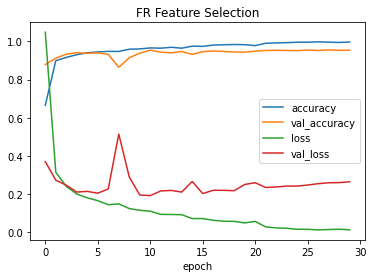

In [46]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [47]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [48]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [49]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.26539793610572815
Test accuracy: 0.9537777900695801
accuracy: 95.38%


# ConvNN(RF) - top 500

## Train/Test split    

In [50]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [51]:
#feature_sort_selected = feature_sort[feature_sort['importance'] > 0.0005]
feature_sort_selected = feature_sort.iloc[:500,:]
feature_sort_selected

,name,importance
3300,MOGAT3,0.003089
57644,FP671120.6,0.002802
12189,KLK4,0.002783
1448,CDH17,0.002782
17545,KLHL14,0.002726
...,...,...
15801,RPL7P26,0.000527
4737,LPPR5,0.000527
72,PRSS22,0.000527
16085,SRL,0.000527


In [52]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [54]:
X_train

,MOGAT3,FP671120.6,KLK4,CDH17,KLHL14,NAPSA,VTN,SFTPB,RDH11,RP11-452C8.1,SOX17,SFTPA1,CRYGN,RP11-53M11.5,FP671120.4,AP001187.9,KLK2,F13B,S1PR5,HRG,KLK3,ITIH2,TRPS1,RP5-1021I20.2,ACSM2B,UGT2B4,PRODH2,FEV,MASP2,SFTPC,FP236383.4,KCNJ10,PRAC2,GRHL2,SFTA3,SLC28A1,NXPE1,LINC00483,CHRNA2,SFTPA2,...,SPDEF,ARL14,ROS1,RP11-14C10.5,NPNT,HEPHL1,DSC3,SLC37A4,CTC-470C15.1,TINAG,RP11-761N21.2,RFPL2,CDC25C,MEIS1,PTPRZ1,AC019129.2,TNS4,DUOXA1,FTH1P10,PLIN2,WDR86,LINC01428,AC021218.2,RP11-363E7.4,SLC9A1,GRIK3,AC002539.1,AXIN2,HNF1A-AS1,MLF1,RGAG4,MSMB,OR51C1P,SCGB1D2,GALNT12,RPL7P26,LPPR5,PRSS22,SRL,KLK5
849,0.000000,0.000000,0.000000,0.808450,0.000000,3.672119,0.000000,4.346068,1.155254,0.0,0.424186,3.167719,0.000000,0.000000,0.465801,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.094042,0.000000,0.000000,0.022084,0.000000,0.0,0.000000,1.362394,0.000000,0.0,0.000000,1.636991,2.317114,0.000000,0.0,0.0,0.0,3.142535,...,1.850602,0.000000,0.841232,0.000000,1.957821,0.000000,0.000000,1.304914,0.000000,0.000000,0.672750,0.0,0.023847,0.571990,0.000000,0.000000,0.247294,1.391259,0.090604,1.135320,0.107780,0.000000,0.000000,1.132814,1.475548,0.000000,0.00000,1.106125,0.000000,1.104966,0.554460,0.000000,0.0,0.000000,1.838268,0.000000,0.000000,1.160419,0.000000,0.000000
1050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.465524,0.0,0.257574,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.773058,0.000000,0.000000,0.0,2.566138,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.110626,1.734314,0.000000,0.137554,0.0,0.0,0.0,0.000000,...,0.840252,0.000000,0.000000,0.000000,0.976508,0.000000,1.323714,1.220133,0.000000,0.000000,1.197140,0.0,1.318770,0.473386,0.270057,0.738661,0.412671,0.124101,0.324407,1.906754,0.000000,0.000000,0.000000,0.601587,1.412625,0.000000,0.00000,0.830541,0.000000,1.760403,0.128463,0.434593,0.0,0.348407,0.000000,0.000000,0.000000,0.906062,0.000000,0.000000
835,0.000000,0.157242,0.601505,0.000000,0.000000,0.690877,0.000000,1.297473,1.752160,0.0,0.041478,0.576785,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.296192,0.444143,0.000000,0.0,0.557529,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.834996,0.000000,0.0,0.000000,1.713397,0.000000,0.000000,0.0,0.0,0.0,0.790730,...,0.000000,0.000000,0.074018,0.000000,2.153278,0.000000,2.326644,1.080129,0.000000,0.000000,1.219640,0.0,0.890011,0.793214,1.808597,0.541247,1.896981,1.401323,0.419719,0.604985,0.157672,0.000000,0.000000,0.999394,1.656942,0.000000,0.00000,0.586131,0.000000,1.853027,0.743807,0.031125,0.0,0.000000,0.731726,0.000000,0.000000,1.741219,0.000000,0.000000
4447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.192705,0.0,0.284720,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.596492,0.000000,0.000000,0.0,0.039429,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.153790,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.084699,0.254706,0.000000,0.000000,0.178859,0.000000,0.000000,1.158807,0.000000,0.000000,0.000000,0.0,0.676008,0.714604,0.000000,1.683316,2.344126,1.128113,0.000000,1.863149,0.000000,0.000000,0.056761,1.827997,1.542713,0.000000,0.00000,0.524409,0.000000,1.120357,0.032112,0.000000,0.0,0.000000,0.842974,0.000000,0.000000,1.891055,0.000000,0.000000
53,0.000000,1.948668,0.000000,0.000000,1.531098,0.094371,0.000000,0.000000,1.352760,0.0,2.316836,0.000000,0.000000,1.133977,2.396390,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.550796,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.164986,0.0,0.818311,1.543859,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,2.420519,0.000000,0.000000,0.000000,0.968613,0.000000,0.233796,1.288215,0.271269,0.000000,1.544402,0.0,1.250054,1.494002,0.000000,2.251137,0.000000,0.000000,1.016395,1.372335,0.220725,0.000000,0.000000,0.910802,1.580645,1.080386,0.00000,1.167842,0.000000,1.778927,0.762819,0.000000,0.0,1.300788,0.740629,0.084183,0.000000,1.487913,0.000000,1.921961
...,...,...,...,...,...,...,...,...,...,...,..

## CONV1D 

In [55]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [56]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [57]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 481, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 481, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 481, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 472, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 472, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 47, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6016)              0

In [58]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [59]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [60]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
169/169 [==============================] - 21s 123ms/step - loss: 1.7351 - acc: 0.4400 - val_loss: 0.2329 - val_acc: 0.9440

Epoch 00001: val_loss improved from inf to 0.23293, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
169/169 [==============================] - 20s 119ms/step - loss: 0.2892 - acc: 0.9048 - val_loss: 0.1635 - val_acc: 0.9502

Epoch 00002: val_loss improved from 0.23293 to 0.16347, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 3/30
169/169 [==============================] - 20s 121ms/step - loss: 0.1553 - acc: 0.9519 - val_loss: 0.1595 - val_acc: 0.9538

Epoch 00003: val_loss improved from 0.16347 to 0.15953, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 4/30
169/169 [==============================] - 20s 120ms/step - loss: 0.1240 - acc: 0.9606 - val_loss: 0.1366 - val_acc: 0.9609

Epoch 00004: val_loss improved from 0.15953 to 0.13657,

In [61]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.18058907985687256
Test accuracy: 0.9724444150924683


Text(0.5, 0, 'epoch')

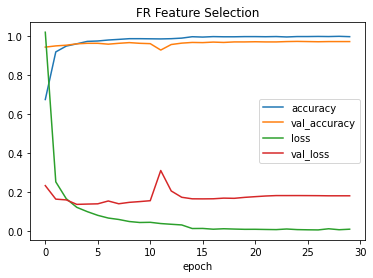

In [62]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [63]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [64]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [65]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.18058907985687256
Test accuracy: 0.9724444150924683
accuracy: 97.24%


# ConvNN(RF) - top 300

## Train/Test split    

In [66]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [67]:
feature_sort_selected = feature_sort.iloc[:300,:]
feature_sort_selected

,name,importance
3300,MOGAT3,0.003089
57644,FP671120.6,0.002802
12189,KLK4,0.002783
1448,CDH17,0.002782
17545,KLHL14,0.002726
...,...,...
13377,PURG,0.000656
3286,TFR2,0.000656
11610,HEPACAM,0.000651
5738,OVOL2,0.000651


In [68]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [70]:
X_train

,MOGAT3,FP671120.6,KLK4,CDH17,KLHL14,NAPSA,VTN,SFTPB,RDH11,RP11-452C8.1,SOX17,SFTPA1,CRYGN,RP11-53M11.5,FP671120.4,AP001187.9,KLK2,F13B,S1PR5,HRG,KLK3,ITIH2,TRPS1,RP5-1021I20.2,ACSM2B,UGT2B4,PRODH2,FEV,MASP2,SFTPC,FP236383.4,KCNJ10,PRAC2,GRHL2,SFTA3,SLC28A1,NXPE1,LINC00483,CHRNA2,SFTPA2,...,ZDHHC22,HMGA1,DSCAM,AQP4,LRRC2,CFHR2,RP11-713P17.3,RIPK4,CH507-513H4.5,KRT6A,RPL7P38,SCD5,GNG7,SLC44A4,RP11-283I3.4,LINC01158,LCN12,RP11-999E24.3,POU3F4,APOH,DUOX2,TTYH2,HMGN2P46,ATP8B1,ESR1,ASGR1,GPR37L1,RP11-114N19.3,CH17-360D5.2,RUFY3,SLC22A2,CYP2S1,HULC,C8B,PEA15,PURG,TFR2,HEPACAM,OVOL2,CDH20
849,0.000000,0.000000,0.000000,0.808450,0.000000,3.672119,0.000000,4.346068,1.155254,0.0,0.424186,3.167719,0.000000,0.000000,0.465801,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.094042,0.000000,0.000000,0.022084,0.000000,0.0,0.000000,1.362394,0.000000,0.0,0.000000,1.636991,2.317114,0.000000,0.0,0.0,0.0,3.142535,...,0.0,2.398765,0.000000,1.489150,0.000000,0.0,0.0,1.076708,0.405134,1.469228,0.0,0.382962,0.811005,2.359632,0.000000,0.000000,0.556286,0.000471,0.0,0.000000,0.544855,0.499250,0.201011,1.839588,0.044883,0.184257,0.000000,0.000000,0.000000,1.129937,0.000000,0.882607,0.0,0.079015,2.339121,0.0,0.000000,0.0,1.477503,0.0
1050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.465524,0.0,0.257574,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.773058,0.000000,0.000000,0.0,2.566138,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.110626,1.734314,0.000000,0.137554,0.0,0.0,0.0,0.000000,...,0.0,2.912051,0.000000,0.000000,0.000000,0.0,0.0,1.435274,0.000000,0.000000,0.0,0.242087,0.180709,0.493004,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.926807,0.200731,1.455283,0.757515,0.109061,0.209082,0.000000,0.000000,1.007618,0.000000,0.921733,0.0,0.000000,2.736137,0.0,1.085994,0.0,1.330262,0.0
835,0.000000,0.157242,0.601505,0.000000,0.000000,0.690877,0.000000,1.297473,1.752160,0.0,0.041478,0.576785,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.296192,0.444143,0.000000,0.0,0.557529,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.834996,0.000000,0.0,0.000000,1.713397,0.000000,0.000000,0.0,0.0,0.0,0.790730,...,0.0,2.506128,0.000000,0.277739,0.000000,0.0,0.0,1.513443,0.317196,3.511951,0.0,1.819393,0.124728,0.241889,0.000000,0.000000,0.744653,0.762830,0.0,0.000000,0.822466,0.706622,0.122293,1.633034,0.000000,0.000000,0.000000,0.000000,0.535041,1.043782,0.000000,2.558877,0.0,0.000000,2.322910,0.0,0.164639,0.0,1.378516,0.0
4447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.192705,0.0,0.284720,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.596492,0.000000,0.000000,0.0,0.039429,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.153790,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,2.496690,0.000000,0.000000,0.000000,0.0,0.0,1.578958,0.000000,0.000000,0.0,0.786010,0.615578,1.350820,0.000000,0.000000,0.079273,0.000000,0.0,0.103834,0.463922,0.431615,0.000000,1.473572,0.000000,0.208826,0.000000,0.000000,0.617325,0.604954,0.000000,0.847522,0.0,0.000000,2.431690,0.0,0.739043,0.0,0.784825,0.0
53,0.000000,1.948668,0.000000,0.000000,1.531098,0.094371,0.000000,0.000000,1.352760,0.0,2.316836,0.000000,0.000000,1.133977,2.396390,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.550796,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.164986,0.0,0.818311,1.543859,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,2.833029,0.000000,0.000000,0.000000,0.0,0.0,1.169070,1.191010,0.100771,0.0,1.527646,0.178553,2.259882,0.000000,0.000000,1.325293,0.000000,0.0,0.000000,0.000000,0.995120,0.271508,1.646923,1.585088,0.000000,0.074854,0.000000,0.000000,0.703209,0.000000,1.613192,0.0,0.000000,2.991211,0.0,0.588367,0.0,1.290742,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## CONV1D 

In [71]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [72]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [73]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 281, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 281, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 281, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 272, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0

In [74]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [75]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [76]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
169/169 [==============================] - 13s 76ms/step - loss: 1.7581 - acc: 0.4441 - val_loss: 0.2959 - val_acc: 0.9200

Epoch 00001: val_loss improved from inf to 0.29592, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
169/169 [==============================] - 13s 75ms/step - loss: 0.3428 - acc: 0.8798 - val_loss: 0.2413 - val_acc: 0.9253

Epoch 00002: val_loss improved from 0.29592 to 0.24131, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 3/30
169/169 [==============================] - 13s 75ms/step - loss: 0.2416 - acc: 0.9242 - val_loss: 0.2268 - val_acc: 0.9316

Epoch 00003: val_loss improved from 0.24131 to 0.22683, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 4/30
169/169 [==============================] - 13s 76ms/step - loss: 0.1894 - acc: 0.9428 - val_loss: 0.1585 - val_acc: 0.9547

Epoch 00004: val_loss improved from 0.22683 to 0.15853, sav

In [77]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.18524613976478577
Test accuracy: 0.9635555744171143


Text(0.5, 0, 'epoch')

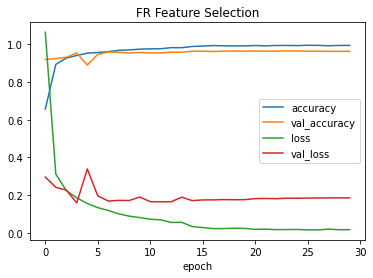

In [78]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [79]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [80]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [81]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.18524613976478577
Test accuracy: 0.9635555744171143
accuracy: 96.36%
